# 정확도(Accuracy)

$정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수$

정확도는 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표이다. <br>
하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지로 성능을 평가하지 않는다.

정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지 예제로 살펴본다.

타이타닉 예제 수행 결과를 보면, <br>
ML 알고리즘을 적용한 후 예측 정확도의 결과가 보통 80%대였지만, 탑승객이 남자인 경우보다 여자인 경우에 생존 확률이 높았기 때문에 별다른 알고리즘 적용 없이 무조건 성별이 여자인 경우 생존으로, 남자인 경우 사망으로 예측 결과를 예측해도 이와 비슷한 수치가 나올 수 있다.

단지 성별 조건 하나만을 가지고 결정하는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생하게 된다.



## 불균형한 레이블 값 분포 / 이진 분류에서 정확도(Accuracy) 사용시 유의할 점

### 예제 1 : [Titanic] 성별에 따른 생존자수 예측 정확도

#### 성별에 따라 생존자를 예측하는 단순한 Classifier

BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고, 성별에 따라 생존자를 예측하는 단순한 Classifier를 생성한다.

BaseEstimator를 상속받으면 Customized 형태의 Estimator를 개발자가 생성할 수 있다.

생성할 클래스는 학습을 수행하는 fit() method는 아무것도 수행하지 않으며 예측을 수행하는 predict() method는 단순히 Sex Feature가 1이면 0, 그렇지 않으면 1로 예측하는 단순한 Classifier이다.

In [134]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator) :
    # fit() method는 아무것도 학습하지 않음
    def fit(self, X, y=None) :
        pass 
    
    # predict() method는 단순히 Sex feature가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X) :
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]) :
            if X['Sex'].iloc[i] == 1 :
                pred[i] = 0
            else :
                pred[i] = 1
        return pred

#### MyDummyClassifier를 이용해 앞서 타이타닉 생존자 예측을 수행

데이터를 가공하고 나서 이 Classifier를 이용해 학습/예측/평가 진행

In [135]:
from sklearn.preprocessing import LabelEncoder

# Null 처리 함수
def fillna(df) :
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# ML Algorithm에 불필요한 Feature 제거
def drop_features(df) :
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df) :
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features :
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 데이터 전처리 함수 호출
def transform_features(df) :
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [136]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도 : {0: .4f}" .format(accuracy_score(y_test, mypredictions)))


Dummy Classifier의 정확도 :  0.7877


#### 결과

: 이렇게 단순한 알고리즘으로 예측을 하더라도 데이터 구성에 따라 정확도 결과는 약 78.77%로 <br>
꽤 높은 수치가 나올 수 있기 때문에 정확도를 평가 지표롤 사용할 때는 매우 신중해야 한다.

특히 정확도는 불균형한(imbalanced) 레이블 값 분포에서 ML 모델의 성능을 평가할 경우, 적합한 평가 지표가 아니다. <br>
( 예를 들어 100개의 데이터가 있고 이 중에 90개의 데이터 레이블이 0, 단 10개의 데이터 레이블이 1이라고 한다면 <br>
무조건 0으로 예측 결과를 반환하는 ML 모델의 경우라도 정확도가 90%가 되기 때문이다. )



### 예제 2 : [MNIST] binary classification으로 변경 후 정확도 측정

MNIST 데이터셋을 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴본다.

MNIST 데이터셋은 0~9까지의 숫자 이미지의 픽셀 정보를 가지고 있으며, <br>
이를 기반으로 숫자 Digit을 예측하는 데 사용된다.

`원래 MNIST 데이터셋은 레이블 값이 0부터 9까지 있는 Multi Label 분류를 위한 것 `인데, 이것을 `레이블 값이 7인 것만 True, 나머지 값은 모두 False로 변환해 이진 분류 문제로 살짝 바꿔` 보겠다.

`즉, 전체 데이터의 10%만 True, 나머지 90%는 False인 불균형 데이터셋으로 변형하는 것이다.`

In [137]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator) :
    def fit(self, X, y) :
        pass 

    # 입력값으로 들어오는 X 데이터셋의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X) :
        return np.zeros( (len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터셋인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 그렇지 않으면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=1)

In [138]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트셋 크기 : ", y_test.shape)
print("테스트셋 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여 정확도는 : {0: .3f}" .format(accuracy_score(y_test, fakepred)))

레이블 테스트셋 크기 :  (450,)
테스트셋 레이블 0과 1의 분포도
0    402
1     48
dtype: int64
모든 예측을 0으로 하여 정확도는 :  0.893


#### 결과

단순히 predict()의 결과를 np.zeros()로 모두 0값으로 반환됨에도 불구하고 450개의 테스트 데이터셋에 수행한 예측 정확도는 90%이다.

단지 모든 것을 0으로만 예측해도 MyFakeClassifier의 정확도가 90%로 유수의 ML 알고리즘과 비슷한 성능을 갖는 말도 안되는 결과이다.

`이처럼 정확도 평가 지표는 불균형한 레이블 데이터셋에서는 성능 수치로 사용돼서는 안된다.
정확도가 가지는 분류 평가 지표로서 이러한 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용하여 ML 모델 성능을 평가해야 한다.`

이를 위해 `오차 행렬(Confusion Matrix)`가 있다.


# 오차행렬(Confusion Matrix)

이진 분류에서 성능 지표로 잘 활용되는 오차행렬은 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고(confused) 있는지도 함께 보여주는 지표이다.

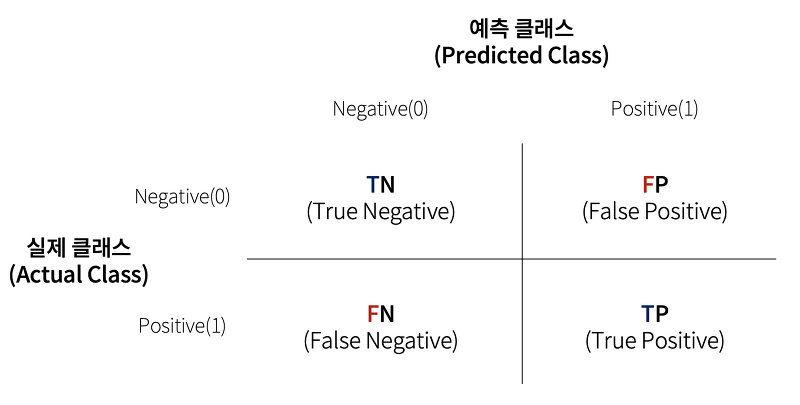

* TN : 예측값 0, 실제값 0
* FP : 예측값 1, 실제값 0
* FN : 예측값 0, 실제값 1
* TP : 예측값 1, 실제값 1

사이킷런은 오차 행렬을 위해 `confusion_matrix()` API 제공.


## confusion_matrix()
정확도(Accuracy) 예제에서 다룬 MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 confusion_matrix()의 인자로 입력해 오차 행렬을 출력

In [139]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

# TN : 402  (예측 : 7 아님, 실제 : 7 아님)
# FP : 0    (예측 : 7 맞음, 실제 : 7 아님)
# FN : 45   (예측 : 7 아님, 실제 : 7 맞음)
# TP : 0    (예측 : 7 맞음, 실제 : 7 맞음)

array([[402,   0],
       [ 48,   0]])

## 정확도(Accuracy), 정밀도(Precision), 재현율(Recall)
TN, FP, FN, TP 값은 Classifier 성능의 여러 면모를 판단할 수 있는 기반 정보를 제공.
이 값을 조합하여 `정확도(Accuracy)`, `정밀도(Precision)`, `재현율(Recall)` 값을 알 수 있음.

$정확도(Accuracy) = (TN + TP) / (TN + FP + FN + TP) = (예측값과 실제값이 동일한 건수)/(모든 데이터 수)$

$정밀도(Precision) = TP / (FP + TP) = (예측값과 실제값이 Positive로 동일한 건수) / (예측값이 Positive인 모든 데이터 수)$

$재현율(Recall) = TP / (FN + TP) = (예측값과 실제값이 Psotivie로 동일한 건수) / (Positive인 모든 데이터 건수)$

`정확도`는 불균형한 이진 분류 데이터셋에서는 Positivie 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Negative로 예측 정확도가 높아지는 경향이 발생한다.<br>
만약 10,000건의 데이터셋에서 9,900건이 Negative이고 100건이 Positive라면 Negative로 예측하는 경향이 더 강해서 TN은 매우 커지고 TP는 매우 작아지게 된다. <br>
또한 Negative로 예측할 때 정확도가 높기 때문에 FN이 매우 작고,<br>
Positive로 예측할 때 정확도가 낮기 때문에 FP 역시 매우 작아진다.

결과적으로 비대칭한 데이터셋에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으로도 분류의 정확도가 매우 높게 나타나는 수치적 판단 오류를 일으키게 된다.

`정밀도와 재현율`은 데이터셋의 예측 성능에 좀 더 초점을 맞춘 평가 지표이다.
앞서 만든 MyFakeClassifer는 Positive로 예측한 TP값이 하나도 없기 때문에 정밀도와 재현율 값 모두 0이다. <br>

`정밀도`는 예측을 Positive한 대상 중에서 예측과 실제값이 Positive로 일치한 데이터의 비율을 뜻한다. Positive 예측 성능을 더욱 정밀하게 측정하기 위한 평가 지표로 `양성 예측도`라고도 불린다.<br>
정밀도가 상대적으로 더 중요한 지표인 경우는 실제 Negative인 데이터 예측을 Positve로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우. <br>
ex) 스팸메일 여부 판단 모델의 경우, 실제 Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우에는 메일을 아예 받지 못하게 돼 업무에 차질이 생김.

`재현율`은 실제 값이 Positive인 대상 중에 예측과 실제값이 Positive로 일치한 데이터의 비율을 뜻한다. `민감도(Seneitivity) 또는 TPR(True Positive Rate)`라고도 불린다.<br>
재현율이 상대적으로 더 중요한 지표인 경우는 실제 Positive인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.
ex) 보험 사기와 같은 금융 사기 적발 모델의 경우, 실제 금융 사기인 Positive건을 Negative로 판단하게 되면 회사에 미치는 손해가 클 것임. 

가장 좋은 성능 평가는 재현율과 정밀도 `모두` 높은 수치를 얻는 것이다. <br>
둘 중 어느 한 평가 지표만 매우 높고, 다른 수치는 매우 낮은 결과를 나타내는 경우는 바람직하지 않다.


## precision_score(), recall_score()

precision_score() : 정밀도 계산
recall_score() : 재현율 계산

In [140]:
# confusion_matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수 생성

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}" .format(accuracy, precision, recall))

In [141]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 타이타닉 데이터 재로드, 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

# 로지스틱 회귀 기반, 생존자 예측
lr_clf = LogisticRegression(solver='liblinear') # solve='liblinear' : 로지스틱 회귀의 최적화 알고리즘 지정. 데이터셋의 이진 분류인 경우 solver는 liblinear가 성능이 좋은 경향이 있다. solver의 기본값은 lbfgs이며 데이터셋이 상대적으로 크고 다중 분류인 경우 적합.
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705


## 정밀도/재현율 트레이드오프

### 임계값(Threshold)

용어 >
* 결정(값) : 레 이블 == 클래스 == 타겟 -> 지도 학습 시 데이터의 학습을 위해 주어지는 정답 데이터
* Feature : 피처 == 속성 -> 타겟값을 제외한 나머지 속성을 제외한 모든 데이터
* record(레코드) : row(행)

분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 경우, 분류의 결정 임계값(Threshold)을 조정해 정밀도 또는 재현율의 수치를 높일 수 있다.

하지만 정밀도와 재현율은 상호 보완적인 평가 지표이기 때문에 어느 한 쪽을 높이면 다른 하나의 수치는 떨어진다. <br>
이를 정밀도/재현율 트레이드오프(Trade-off)라고 부른다.

scikit-learn의 분류 알고리즘은 예측 데이터가 특정 레이블에 속하는지를 계산하기 위해 먼저 개별 레이블별로 결정 확률을 구한다.
그리고 예측 확률이 큰 레이블값으로 예측하게 된다.
가령 이진 분류 모델에서 특정 데이터가 0이 될 확률이 10%, 1이 될 확률이 90%로 예측됐다면 최종 예측은 더 큰 확률을 가진, 즉 90%확률을 가진 1로 예측한다.

`일반적으로 이진 분류에서는 이 임계값을 0.5, 즉 50%로 정하고 이 기준보다 확률이 크면 Positive, 작으면 Negative로 결정한다`

scikit-learn은 개별 데이터별로 예측 확률을 반환하는 method인 predict_proba()를 제공한다. <br>
<u>predict_proba() method는 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하며 test feature 데이터셋을 파라미터로 입력해주면 <br>
test feature 레코드의 개별 클래스 예측 확률을 반환한다.</u><br>
predict() method와 유사하지만 단지 반환 결과가 예측 결과 클래스값이 아닌 예측 확률 결과이다.


이진 분류에서 predict_proba()를 수행해 반환되는 ndarray는
첫 번째 칼럼이 클래스 값 0에 대한 예측 확률, 두 번째 칼럼이 클래스 값 1에 대한 예측 확률이다.

In [142]:
# 타이타닉 생존자 데이터를 학습한 LogisticRegression 객체에서 predict_proba() method를 수행한 뒤 반환 값을 확인하고, 
# predict() method 결과와 비교

pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)

print("pred_proba()결과 Shape : {0}" .format(pred_proba.shape)) 
print("pred_proba array에서 앞 3개만 샘플로 추출\n : ", pred_proba[:3])

# 예측 확률 array와 예측 결과값 array를 병합(concatenate)해 예측 확률과 결과값을 한눈에 확인
pred_prob_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측\n", pred_prob_result[:3])


# 반환 결과인 ndarray는 0과 1에 대한 확률을 나타내므로 첫 번째 칼럼 값과 두 번째 칼럼 값을 더하면 1이 된다.
# 그리고 맨 마지막 줄인 predict() method의 결과 비교에서도 나타나듯이, 두 개의 칼럼 중에서 더 큰 확률 값으로 predict() method가 최종 예측하고 있다


pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출
 :  [[0.44935225 0.55064775]
 [0.86335511 0.13664489]
 [0.86429643 0.13570357]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측
 [[0.44935225 0.55064775 1.        ]
 [0.86335511 0.13664489 0.        ]
 [0.86429643 0.13570357 0.        ]]


#### Binarizer Class
scikit-learn의 predict()는 predict_prob() method가 반환하는 확률 값을 가진 ndarray에서 정해진 임계값(default : 0.5)을 만족하는 ndarray의 칼럼 위치를 최종 예측 클래스로 결정한다고 했다.

이러한 구현을 위해 scikit-learn의 Binarizer 클래스를 이용한다.

In [143]:
# threshold 변수를 특정 값으로 설정하고 Binarizer 클래스를 개체로 생성.
# Binarizer 객체의 fit_transform() method를 이용해
# numpy ndarray를 입력하면 입력된 ndarray의 값을 지정된 threshold보다 작으면 0, 아니며 1로 반환

from sklearn.preprocessing import Binarizer

X = [
    [1, -1, 2],
    [2, 0, 0],
    [0, 1.1, 1.2]
]

# X의 개별 원소들이 threshold값 이하면 0, 초과면 1 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


#### pred_proba 객체 변수에 threshold을 지정한 Binarizer 클래스 적용해 최종 예측값

앞서 LogisticRegression 객체의 predict_prob() method로 구한 각 클래스별 예측 확률값인 pred_proba 객체 변수에 분류 결정 임계값(threshold)을 0.5로 지정한 Binarizer Class를 적용해 최종 예측값을 구한다.

이렇게 구한 최종 예측값에 대해 get_clf_eval() 함수를 적용해 평가 지표도 출력한다.

In [144]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값, 분류 결정 임계값을 0.5로 설정
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 Column, 즉 Positive Class Column 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 이 의사 코드로 계산된 평가 지표는 앞 예제의 타이타닉 데이터로 학습된 로지스틱 회귀 Classifier 객체에서 호출된 predict()로 계산된 지표 값과 정확히 같다.
# predict()가 predict_proba()에 기반함을 알 수 있다.

오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705


In [145]:
# 만약 이 분류 결정 임계값을 낮추면 평가 지표가 어떻게 변할까? 

# 0.5에서 0.4로 낮춤
custom_threshold = 0.4

# predict_proba() 반환값의 두 번째 Column, 즉 Positive Class Column 하나만 추출해 Binarizer 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도 :  0.8212, 정밀도 :  0.7042, 재현율 :  0.8197


#### 결론

임계값을 낮추니 재현율이 올라가고 정밀도가 떨어졌다.

이유?
분류 결정 임계값은 Positive 예측값을 결정하는 확률의 기준이 된다. <br>
확률이 0.5가 아닌 0.4로부터 Positive로 예측을 너그럽게 하기 때문에<br>
임계값을 낮출수록 True값이 많아지게 된다.
Positive 예측값이 많아지면 상대적으로 재현율 값이 높아진다.
Positive 예측을 많이 하다 보니 실제 Positive를 Negative로 예측하는 횟수가 상대적으로 줄어들기 떄문.

임계값이 0.5에서 0.4로 낮아지면서 <br>
TP : 47 -> 50 으로 좋아짐. 이에 따라, 재현율 : 0.7705 -> 0.8197 으로 좋아짐. <br>
FN : 14 -> 11 으로 나빠짐. 이에 따라, 정밀도 : 0.8246 -> 0.7042 으로 나빠짐. <br>

In [146]:
# 이번에는 임계값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표를 조사

# 테스트를 수행할 모든 임계값을 리스트 객체로 저장
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds) :
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임계값 : ", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print("")

get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


# 임계값이 0.45인 경우, default인 0.5인 경우와 비교해서 정확도는 동일하고
# 정밀도는 약간 떨어졌으나 재현율이 올랐다.
# 재현율을 향상시키면서 다른 수치를 어느 정도 감소하는 희생을 해야 한다면 임계값 0.45가 가장 적당해 보임

임계값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 :  0.8212, 정밀도 :  0.7042, 재현율 :  0.8197

임계값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 :  0.8547, 정밀도 :  0.7869, 재현율 :  0.7869

임계값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705

임계값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 :  0.8715, 정밀도 :  0.8654, 재현율 :  0.7377

임계값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 :  0.8771, 정밀도 :  0.8980, 재현율 :  0.7213



### precision_recall_curve()

지금까지 임계값 변화에 따른 평가 지표 값을 알아보는 코드를 작성했는데,
scikit-learn은 이와 유사한 precision_recall_curve() API를 제공한다.

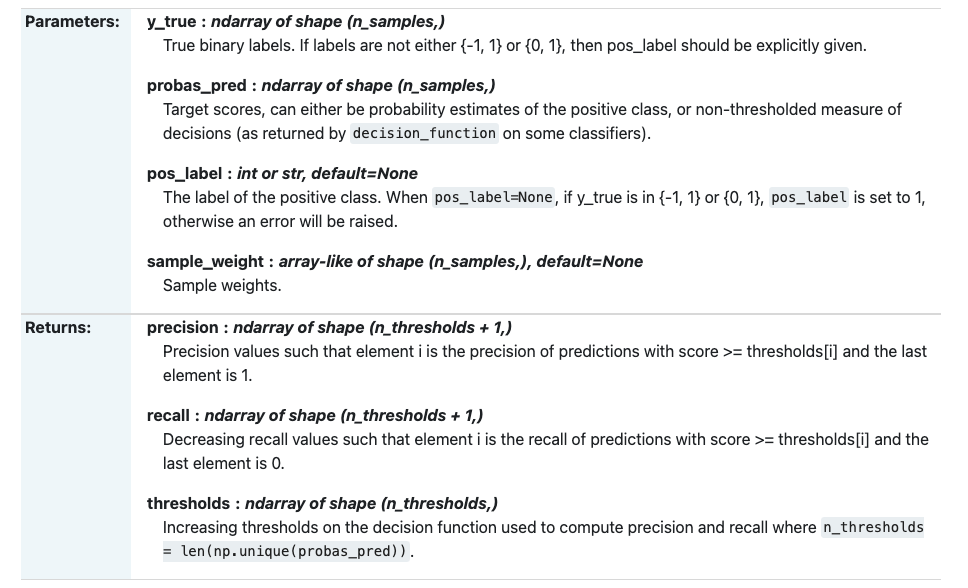

### precision_recall_curve()를 이용한 타이타닉 예측 모델의 임계값별 정밀도와 재현율

precision_recall_curve()은 일반적으로 0.11 ~ 0.95 정도의 임계값을 담은 넘파이 ndarray와 이 임계값에 해당하는 정밀도 및 재현율 값을 담은 넘파인 ndarray를 반환한다.

반환되는 임계값이 너무 많이 구성되어 있기 때문에, 샘플로 10건만 추출하되, 
임계값을 15단계로 추출해 좀 더 큰 값의 임계값과 그 때의 정밀도와 재현율 값을 살펴본다


In [147]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실제값 데이터셋과 레이블 값이 1일 때의 예측 확률을 precision_recall_curve() 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임계값 배열의 Shape : ", thresholds.shape)

# 반환된 임계값 배열 row가 147건이므로 샘플로 10건만 추출하되, 임계값을 15 step으로 추출
thr_idx = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개 : ", thr_idx)
print("샘플용 10개의 임계값 : ", np.round(thresholds[thr_idx], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print("샘플 임계값별 정밀도 : ", np.round(precisions[thr_idx], 3))
print("샘플 임계값별 재현율 : ", np.round(recalls[thr_idx], 3))

# 추출된 임계값 샘플 10개에 해당하는 정밀도 값과 재현율 값을 살펴보면 임계값이 증가할수록 정밀도 값은 동시에 높아지나 재현율 값을 낮아짐을 알 수 있다.

반환된 분류 결정 임계값 배열의 Shape :  (165,)
샘플 추출을 위한 임계값 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값 :  [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도 :  [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율 :  [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


### precision_recall_curve()를 이용한 타이타닉 예측 모델의 임계값별 정밀도와 재현율 시각화

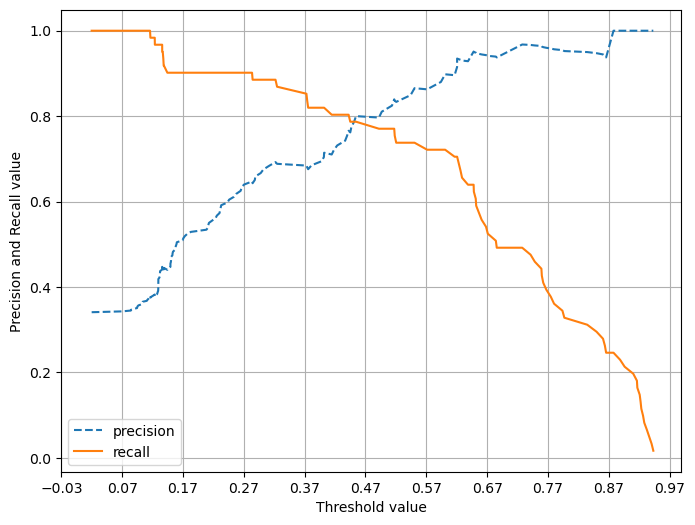

In [148]:
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker

def precision_recall_curve_plot(y_test, pred_proba_c1) :
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, threshols = precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도와 재현율 값으로 각각 Plot (정밀도는 점선)
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0 : threshold_boundary], ls='--', label='precision')
    plt.plot(thresholds, recalls[0 : threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show();

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

# 임계값을 증가시킬수록 재현율 값이 낮아지고 정밀도 값이 높아지는 반대의 양상을 확인.
# 로지스틱 회귀 기반의 타이타닉 생존자 예측 모델의 경우 임계값이 약 0.45 지점에서 재현율과 정밀도가 동일해지는 모습을 확인.

# F1 Score

F1 Score는 정밀도와 재현율을 결합한 지표이다.
정밀도와 재현율이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가진다.

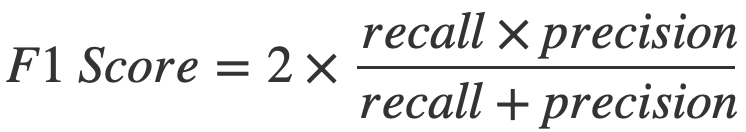

ex >
만일 A 예측 모델의 경우 정밀도가 0.9, 재현율이 0.1로 극단적인 차이가 나고 <br>
B 예측 모델은 정밀도가 0.5, 재현율이 0.5로 정밀도와 재현율이 큰 차이가 없다면 <br>
A 예측 모델의 F1 Score는 0.18이고, B 예측 모델의 F1 Score는 0.5로 <br>
B 모델이 A 모델에 비해 우수한 F1 Score를 갖게 된다.

## 타이타닉 생존자 모델의 F1 Score

In [149]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 타이타닉 데이터 재로드, 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=11)

# 로지스틱 회귀 기반, 생존자 예측
lr_clf = LogisticRegression(solver='liblinear') # solve='liblinear' : 로지스틱 회귀의 최적화 알고리즘 지정. 데이터셋의 이진 분류인 경우 solver는 liblinear가 성능이 좋은 경향이 있다. solver의 기본값은 lbfgs이며 데이터셋이 상대적으로 크고 다중 분류인 경우 적합.
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705


In [150]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred)
print("F1 Score : {0: .4f}" .format(f1))

F1 Score :  0.7966


## 임계값 변화시키면서 F1 Score를 포함한 평가 지표

In [151]:
# confusion_matrix, accuracy, precision, recall 등의 평가를 한꺼번에 호출하는 get_clf_eval() 함수 생성

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_eval_by_threshold(y_test, pred_prob_c1, thresholds) :
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_prob_c1)
        custom_predict = binarizer.transform(pred_prob_c1)
        print("임계값 : ", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        print("")

def get_clf_eval(y_test, pred) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 Score 추가
    f1 = f1_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}, F1 : {3: .4f}" .format(accuracy, precision, recall, f1))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

# F1 Score는 임계값이 0.6일 때 가장 좋은 값을 보여준다.
# 하지만 임계값이 0.6인 경우 재현율이 크게 감소하고 있으니 주지해야 한다.

임계값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 :  0.8212, 정밀도 :  0.7042, 재현율 :  0.8197, F1 :  0.7576

임계값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 :  0.8547, 정밀도 :  0.7869, 재현율 :  0.7869, F1 :  0.7869

임계값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705, F1 :  0.7966

임계값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 :  0.8715, 정밀도 :  0.8654, 재현율 :  0.7377, F1 :  0.7965

임계값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 :  0.8771, 정밀도 :  0.8980, 재현율 :  0.7213, F1 :  0.8000



# ROC 곡선과 AUC

ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표이다.

ROC 곡선은 FPR(False Positive Rate), TPR(True Positive Rate)이 어떻게 변하는지 나타내는 곡선이다. <br>
X축을 FPR, Y축을 TPR로 잡으면 FPR의 변화에 따른 TPR의 변화가 곡선 형태로 나타난다.<br>

일반적응로 ROC 곡선 자체는 FPR과 TPR의 변화 값을 보는 데 이용하며,<br>
분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정한다.<br>
AUC(Area Under Curve)값은 ROC 곡선 밑의 면적을 구한 것으로서, 일반적으로 1에 가까울수록 좋은 수치이다.<br>

* TPR = 재현율 = 민감도 = TP / (FN + TP)
  민감도는 실제값 Positive가 정확히 예측돼야 하는 수준을 나타낸다 (질병이 있는 사람은 질병이 있는 것으로 판정)
* TNR = 특이성 = TN / (FP + TN)
  특이성은 실제값 Negative가 정확히 예측돼야 하는 수준을 나타낸다 (질병이 없는 사람은 질병이 없는 것으로 판정)
* FPR = FP / (FP + FN) = 1 - TNR

## roc_curve()를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR, 임계값

In [152]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨, 이를 제외하기 위해 np.arange는 1부터 시작
thr_idx = np.arange(1, thresholds.shape[0], 5)
print("샘플 추출을 위한 임계값 배열의 index : ", thr_idx)
print("샘플 index로  추출한 임계값 : ", np.round(thresholds[thr_idx], 2))

# 5 step 단위로  추출된 임계값에 따른 FPR, TPR 값
print("샘플 임계값별 FPR : ", np.round(fprs[thr_idx], 3))
print("샘플 임계값별 TPR : ", np.round(tprs[thr_idx], 3))

# 임계값이 1에 가까운 값에서 점점 작아지면서 
# FPR이 점점 커지고, TPR은 가파르게 커짐을 알 수 있다.

샘플 추출을 위한 임계값 배열의 index :  [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로  추출한 임계값 :  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임계값별 FPR :  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임계값별 TPR :  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


## roc_curve()를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR, 임계값 시각화

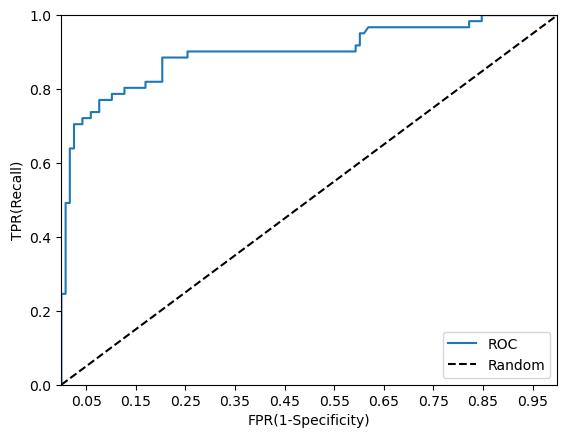

In [153]:
def roc_curve_plot(y_test, pred_proba_c1) :
    # 임계값에 따른 FPR, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)

    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')

    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')

    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.xlabel('FPR(1-Specificity)'); plt.ylabel('TPR(Recall)')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

## AUC

In [154]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print("ROC AUC 값 : {0: .4f}". format(roc_score))

ROC AUC 값 :  0.8987


In [155]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_eval_by_threshold(y_test, pred_prob_c1, thresholds) :
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds :
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_prob_c1)
        custom_predict = binarizer.transform(pred_prob_c1)
        print("임계값 : ", custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_prob_c1)
        print("")
        
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0: .4f}, 정밀도 : {1: .4f}, 재현율 : {2: .4f}, F1 : {3: .4f}, AUC : {4: .4f}" .format(accuracy, precision, recall, f1, roc_auc))

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 :  0.8212, 정밀도 :  0.7042, 재현율 :  0.8197, F1 :  0.7576, AUC :  0.8987

임계값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 :  0.8547, 정밀도 :  0.7869, 재현율 :  0.7869, F1 :  0.7869, AUC :  0.8987

임계값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 :  0.8659, 정밀도 :  0.8246, 재현율 :  0.7705, F1 :  0.7966, AUC :  0.8987

임계값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 :  0.8715, 정밀도 :  0.8654, 재현율 :  0.7377, F1 :  0.7965, AUC :  0.8987

임계값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 :  0.8771, 정밀도 :  0.8980, 재현율 :  0.7213, F1 :  0.8000, AUC :  0.8987

